# SynAnalyzer_PlotSynAnalysis.ipynb
Created by: JFranco | 6 AUG 2024

This Python notebook is in the Synapse Analyzer pipeline. The purpose of the notebook is to plot the results of the SynAnalyzer.ijm

In [3]:
import datetime
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import glob
import seaborn as sns
#import math
#from pprint import pprint
#from scipy import stats
#from statannotations.Annotator import Annotator

In [4]:
#                   *** GET TIME OF ANALYSIS START ***
# could turn this into a module?
toa = str(datetime.datetime.today()).split()                                   #Time of analysis
today = toa[0]
now = toa[1]
timestamp = today.replace('-','')+'-'+now.replace(':','')[:6]

In [27]:
#                *** WHAT TO ANALYZE // WHERE TO GET/STORE **
# Key identifiers
batchID = 'SynAnalysis_BclwSNHL_NeonatalAAV'
mdSFields = ['AnimalID','Treatment','NoiseExposed']
mdIFields = ['Freq','NoHCRecon']

# Directories 
#   existing ones 
dirMain = '/Users/joyfranco/Dropbox (Partners HealthCare)/JF_Shared/Data/WSS/'
dirBA = dirMain+'BatchAnalysis/'+batchID+'/'
dirMD = dirBA+'Metadata/'
dirData = dirBA+'SAR.Analysis/'

#   ones that need to be made    
dirRes = dirBA+'SAR.Results/'
dirTR = dirRes+timestamp+'/'

# Files to access
fnMDSamp = batchID+'.Metadata.Samples.csv'
fnMDIms = batchID+'.Metadata.Imaging.csv'
fnBM = 'SynAnalyzerBatchMaster.csv'

In [13]:
#           *** INITIALIZE RUN SPECIFIC DIRECTORY ETC FOR STORING RESULTS **
# Create directory for storing spreadsheetS and summary plotS for this run
if not os.path.exists(dirRes): os.mkdir(dirRes)
if not os.path.exists(dirTR): os.mkdir(dirTR)

In [110]:
#  Load the files
dfSamps = pd.read_csv(dirMD+fnMDSamp)
dfSamps.reset_index(inplace=True)
dfIms = pd.read_csv(dirMD+fnMDIms)
dfIms.reset_index(inplace=True)
dfBM = pd.read_csv(dirData+fnBM)
dfBM.reset_index(inplace=True)

In [111]:
# Add the sample ID to the batch master
dfBM['SampleID'] = dfBM['ImageName'].str.split('.T').str[0]

In [112]:
# Get list of images and iterate through to add key metadata for plotting
ims = dfBM['ImageName']
for im in ims:
    # Get the index in the batch master 
    inBM = dfBM.index[dfBM['ImageName']==im].tolist()[0]
    # Get the index in the sample md sheet based on the sample ID
    sampID = im.split('.T')[0]
    inSamp = dfSamps.index[dfSamps['SampleID']==sampID].tolist()[0]
    # Add information from the Samples metadata sheet
    for field in mdSFields:
        val = dfSamps.loc[inSamp][field]
        dfBM.at[inBM, field] = val
    # Get the index in the ims md sheet based on image name
    imName = im.split('.czi')[0]
    inIms = dfIms.index[dfIms['ImageName']==imName].tolist()[0]
    # Add information from the Samples metadata sheet
    for field in mdIFields:
        val = dfIms.loc[inIms][field]
        dfBM.at[inBM, field] = val


dfBM['Freq'] = dfBM['Freq'].astype(str)

# Save the updated batch master
dfBM.to_csv(dirTR+batchID+'.BatchMaster.Results.csv') 

In [113]:
# Add up totals for all categories
dfBM['AllXYZs'] = dfBM['PreSyn_nSynapses'].astype('int64')+dfBM['PreSyn_nDoublets'].astype('int64')+dfBM['PreSyn_nOrphans'].astype('int64')+dfBM['PreSyn_nGarbage'].astype('int64')+dfBM['PreSyn_nUnclear'].astype('int64')
# Calculate Averages for each image
dfBM['AvgPunctaPerHC'] = dfBM['AllXYZs'].astype('int64')/dfBM['NoHCRecon'].astype('int64')
dfBM['AvgSynPerHC'] = dfBM['PreSyn_nSynapses'].astype('int64')/dfBM['NoHCRecon'].astype('int64')
dfBM['AvgOrphPerHC'] = dfBM['PreSyn_nOrphans'].astype('int64')/dfBM['NoHCRecon'].astype('int64')
# Save the updated batch master
dfBM.to_csv(dirTR+batchID+'.BatchMaster.Results.csv') 

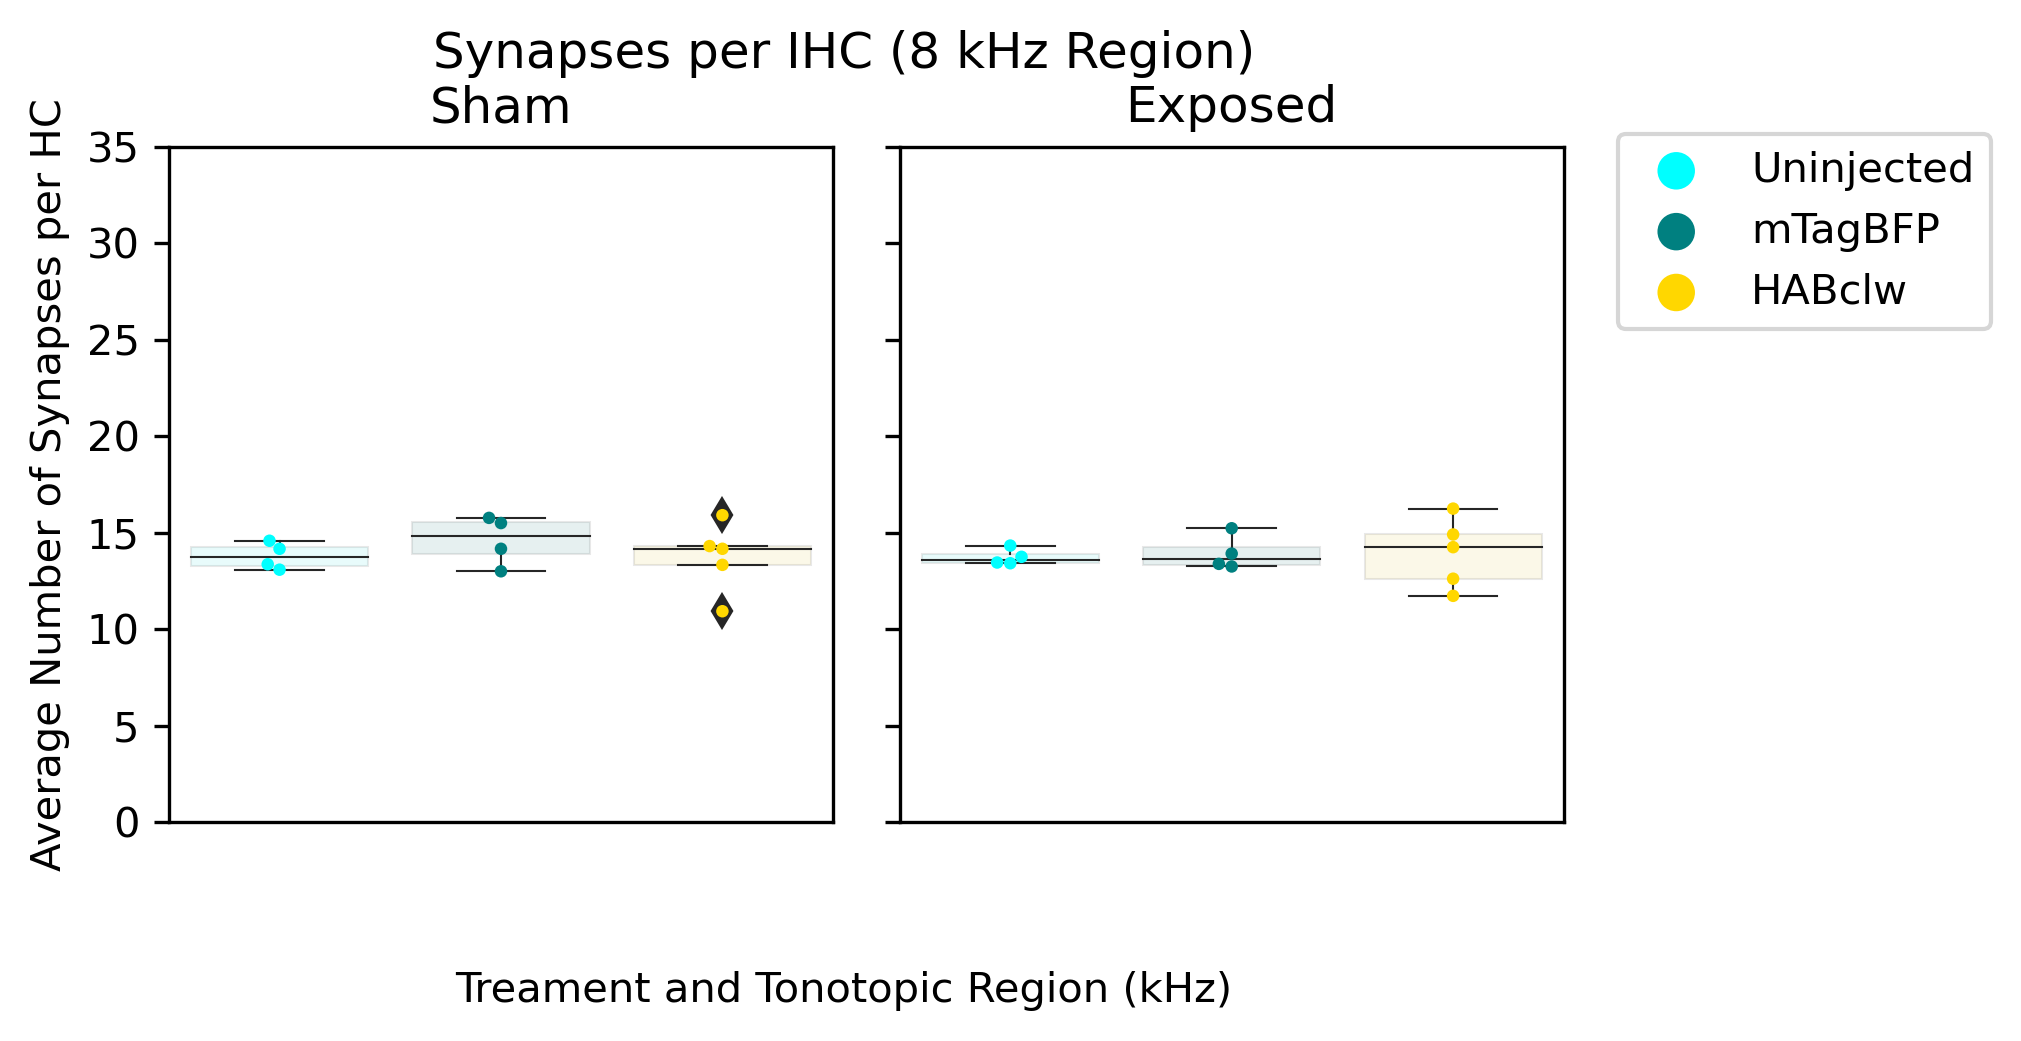

In [118]:
plot = 'SynPerHC'
plottype = 'BoxSwarm'
region = 'All'
title = 'Synapses per IHC (8 kHz Region)'
# Order is the color coded condition along the x-axis at the lowest level (repeating between panels)
order = ['Uninjected','mTagBFP','HABclw']
colors = {order[0]:'aqua' , order[1]:'teal', order[2]:'gold'}
hue = 'Treatment'
x = 'Treatment'
y = 'AvgSynPerHC'
xlab = 'Treament and Tonotopic Region (kHz)'
ylab = 'Average Number of Synapses per HC'
markersize = 3

fig, axes = plt.subplots(1, 2, dpi=300,figsize=(6,3), sharey = True, sharex= True)
(ax1, ax2) = axes
fig.suptitle(title)
fig.text(0.5, -.1, xlab, ha='center')
plt.subplots_adjust(top = 0.85, bottom=0.1, hspace=.3, wspace=.1)

# *** MAKE THE FIRST SUBPLOT FOR 8 kHz DATA ***
ax1 = plt.subplot(121)  
ax1.title.set_text('Sham')
ax1 = sns.swarmplot(data=dfBM[(dfBM['Freq'] == '8.0') & (dfBM['NoiseExposed'] == 'Sham')], 
              x=x,y=y, hue=hue, palette=colors, order=order, size=markersize, legend = False, dodge = False)
sns.boxplot(data=dfBM[(dfBM['Freq'] == '8.0') & (dfBM['NoiseExposed'] == 'Sham')],
            x=x, y=y, hue=hue, palette=colors, order=order, boxprops={'alpha': 0.1}, ax=ax1, dodge = False,
           linewidth=.5)
ax1.set(ylabel=ylab)
ax1.set_ylim((0, 35))
ax1.get_legend().remove()
ax1.get_xaxis().set_visible(False)

# *** MAKE THE SECOND SUBPLOT FOR 16 kHz FREQUENCY DATA ***
ax2 = plt.subplot(122)  
ax2.title.set_text('Exposed')
ax2 = sns.swarmplot(data=dfBM[(dfBM['Freq'] == '8.0') & (dfBM['NoiseExposed'] == 'Exposed')], 
              x=x,y=y, hue=hue, palette=colors, order=order, size=markersize, legend = False, dodge = False)
sns.boxplot(data=dfBM[(dfBM['Freq'] == '8.0') & (dfBM['NoiseExposed'] == 'Exposed')],
            x=x, y=y, hue=hue, palette=colors, order=order, boxprops={'alpha': 0.1}, ax=ax2, dodge = False,
           linewidth=.5)
ax2.get_legend().remove()
ax2.axes.get_xaxis().set_visible(False)


# *** SETUP THE LEGEND FOR BOTH SUBPLOTS ***
plt.legend([order[0], order[1], order[2]], bbox_to_anchor=(1.05, 1.05),loc='upper left',   
           markerscale=3,fancybox=True)

plt.savefig(dirTR+batchID+'.'+plot+'.'+plottype+'.'+region+'.png',  bbox_inches='tight', dpi = 300,
            format = 'png')

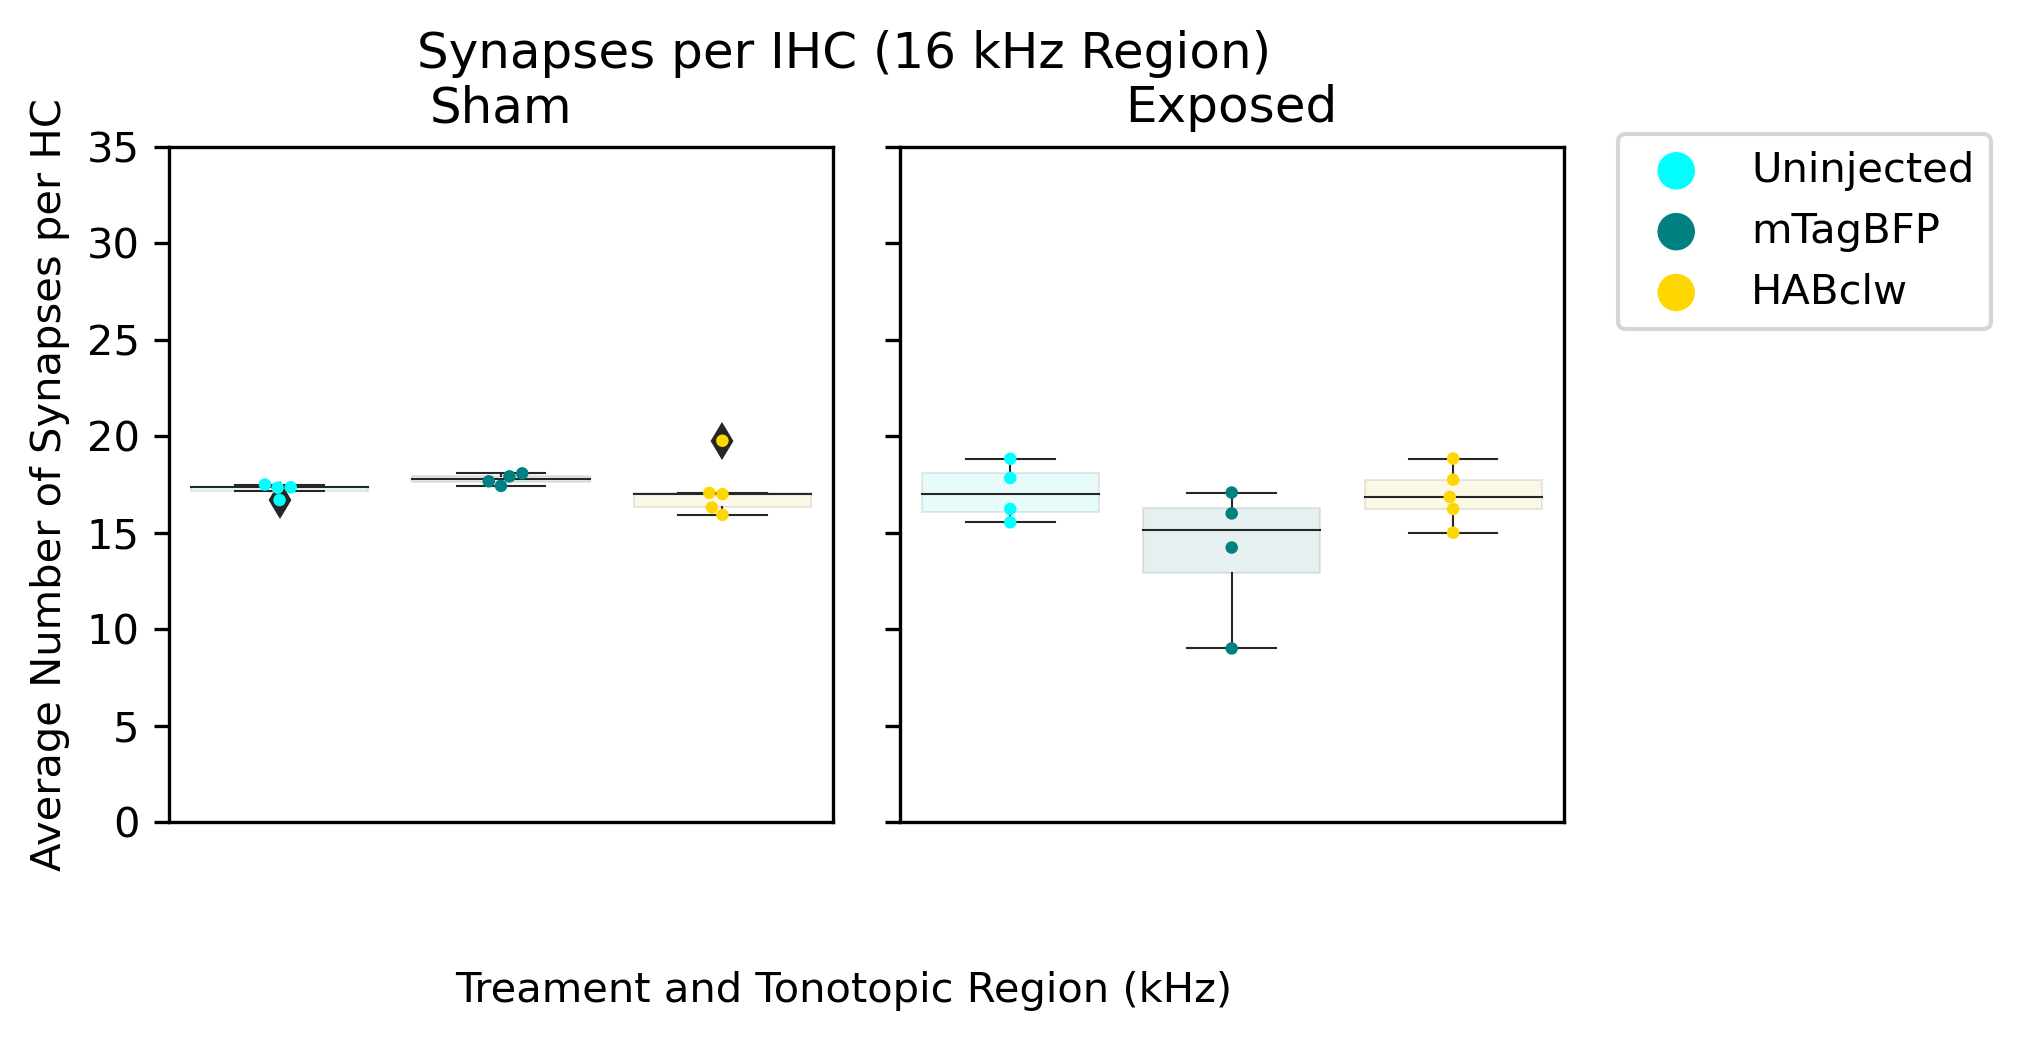

In [120]:
plot = 'SynPerHC'
plottype = 'BoxSwarm'
region = 'All'
title = 'Synapses per IHC (16 kHz Region)'
# Order is the color coded condition along the x-axis at the lowest level (repeating between panels)
order = ['Uninjected','mTagBFP','HABclw']
colors = {order[0]:'aqua' , order[1]:'teal', order[2]:'gold'}
hue = 'Treatment'
x = 'Treatment'
y = 'AvgSynPerHC'
xlab = 'Treament and Tonotopic Region (kHz)'
ylab = 'Average Number of Synapses per HC'
markersize = 3

fig, axes = plt.subplots(1, 2, dpi=300,figsize=(6,3), sharey = True, sharex= True)
(ax1, ax2) = axes
fig.suptitle(title)
fig.text(0.5, -.1, xlab, ha='center')
plt.subplots_adjust(top = 0.85, bottom=0.1, hspace=.3, wspace=.1)

# *** MAKE THE FIRST SUBPLOT FOR 8 kHz DATA ***
ax1 = plt.subplot(121)  
ax1.title.set_text('Sham')
ax1 = sns.swarmplot(data=dfBM[(dfBM['Freq'] == '16.0') & (dfBM['NoiseExposed'] == 'Sham')], 
              x=x,y=y, hue=hue, palette=colors, order=order, size=markersize, legend = False, dodge = False)
sns.boxplot(data=dfBM[(dfBM['Freq'] == '16.0') & (dfBM['NoiseExposed'] == 'Sham')],
            x=x, y=y, hue=hue, palette=colors, order=order, boxprops={'alpha': 0.1}, ax=ax1, dodge = False,
           linewidth=.5)
ax1.set(ylabel=ylab)
ax1.set_ylim((0, 35))
ax1.get_legend().remove()
ax1.get_xaxis().set_visible(False)

# *** MAKE THE SECOND SUBPLOT FOR 16 kHz FREQUENCY DATA ***
ax2 = plt.subplot(122)  
ax2.title.set_text('Exposed')
ax2 = sns.swarmplot(data=dfBM[(dfBM['Freq'] == '16.0') & (dfBM['NoiseExposed'] == 'Exposed')], 
              x=x,y=y, hue=hue, palette=colors, order=order, size=markersize, legend = False, dodge = False)
sns.boxplot(data=dfBM[(dfBM['Freq'] == '16.0') & (dfBM['NoiseExposed'] == 'Exposed')],
            x=x, y=y, hue=hue, palette=colors, order=order, boxprops={'alpha': 0.1}, ax=ax2, dodge = False,
           linewidth=.5)
ax2.get_legend().remove()
ax2.axes.get_xaxis().set_visible(False)


# *** SETUP THE LEGEND FOR BOTH SUBPLOTS ***
plt.legend([order[0], order[1], order[2]], bbox_to_anchor=(1.05, 1.05),loc='upper left',   
           markerscale=3,fancybox=True)

plt.savefig(dirTR+batchID+'.'+plot+'.'+plottype+'.'+region+'.png',  bbox_inches='tight', dpi = 300,
            format = 'png')

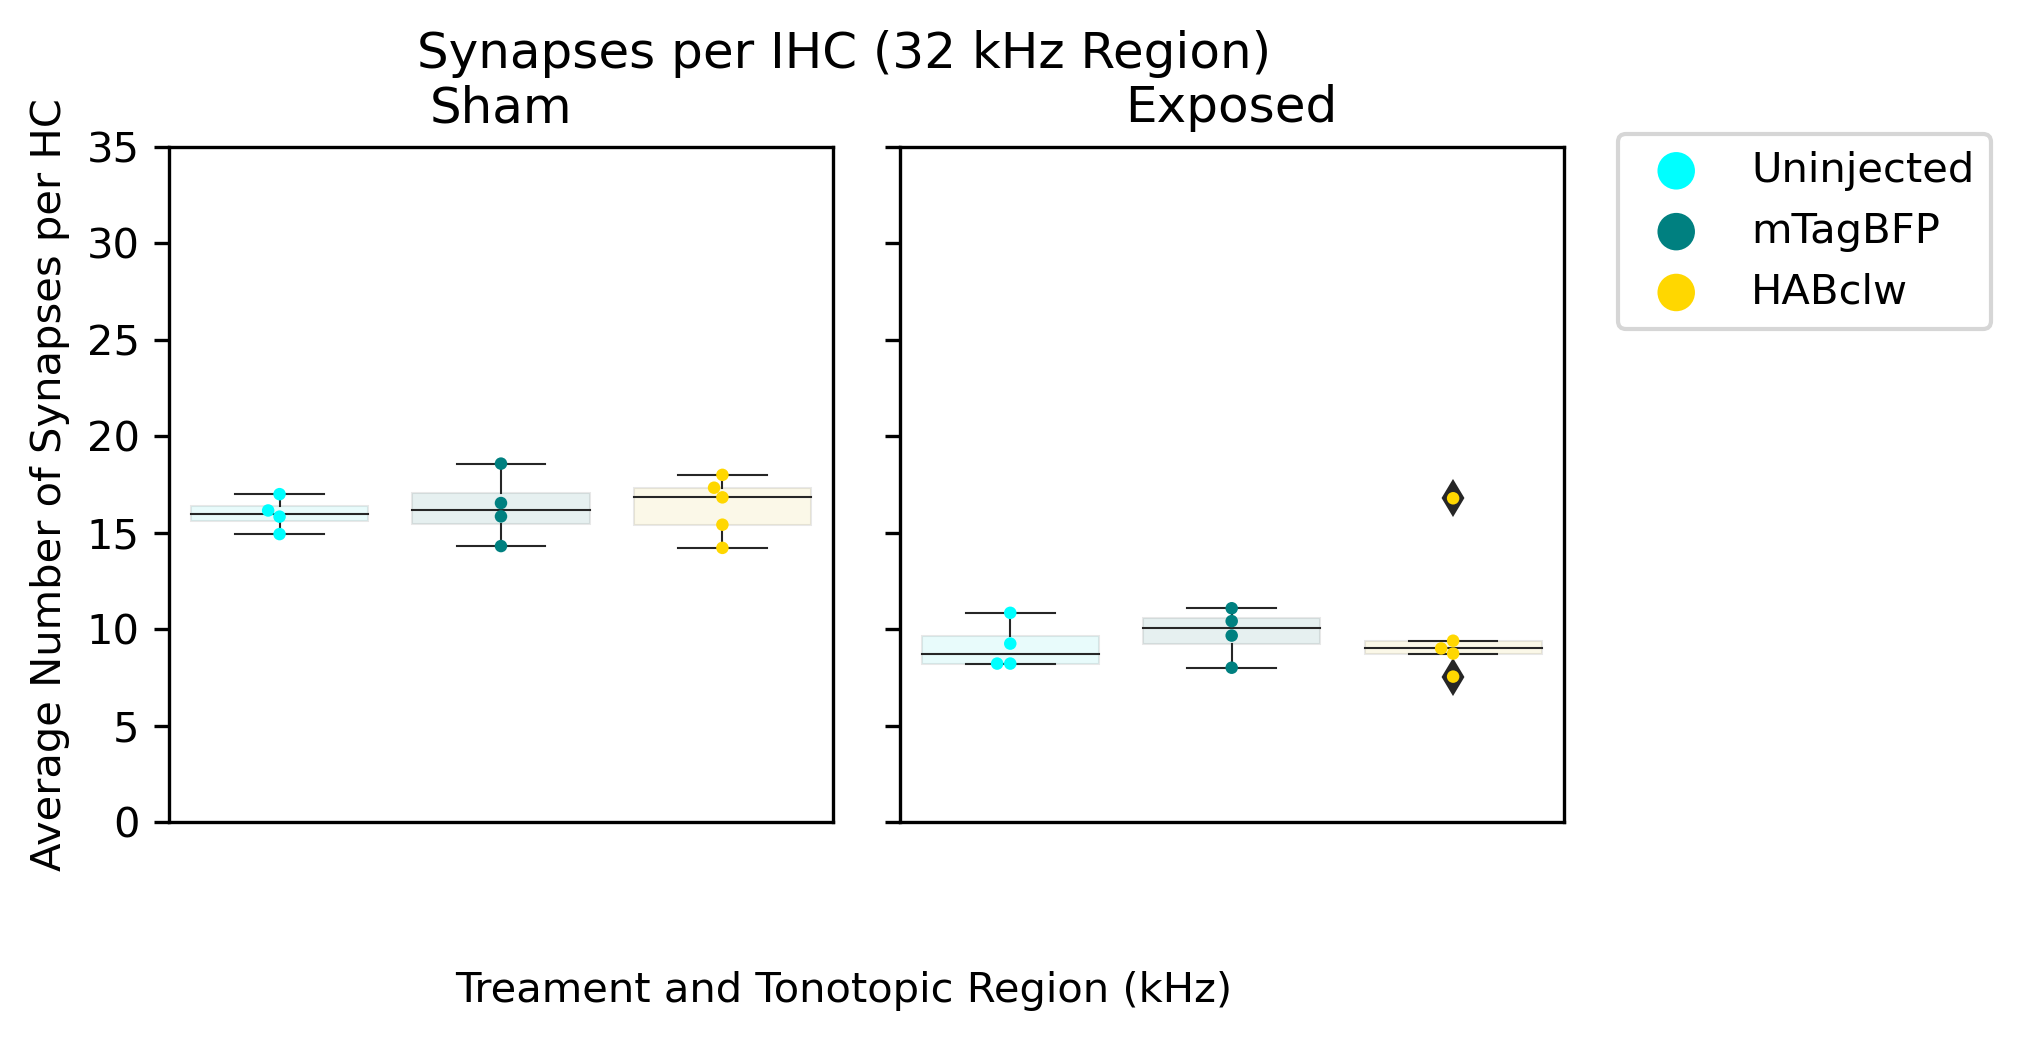

In [119]:
plot = 'SynPerHC'
plottype = 'BoxSwarm'
region = 'All'
title = 'Synapses per IHC (32 kHz Region)'
# Order is the color coded condition along the x-axis at the lowest level (repeating between panels)
order = ['Uninjected','mTagBFP','HABclw']
colors = {order[0]:'aqua' , order[1]:'teal', order[2]:'gold'}
hue = 'Treatment'
x = 'Treatment'
y = 'AvgSynPerHC'
xlab = 'Treament and Tonotopic Region (kHz)'
ylab = 'Average Number of Synapses per HC'
markersize = 3

fig, axes = plt.subplots(1, 2, dpi=300,figsize=(6,3), sharey = True, sharex= True)
(ax1, ax2) = axes
fig.suptitle(title)
fig.text(0.5, -.1, xlab, ha='center')
plt.subplots_adjust(top = 0.85, bottom=0.1, hspace=.3, wspace=.1)

# *** MAKE THE FIRST SUBPLOT FOR 8 kHz DATA ***
ax1 = plt.subplot(121)  
ax1.title.set_text('Sham')
ax1 = sns.swarmplot(data=dfBM[(dfBM['Freq'] == '32.0') & (dfBM['NoiseExposed'] == 'Sham')], 
              x=x,y=y, hue=hue, palette=colors, order=order, size=markersize, legend = False, dodge = False)
sns.boxplot(data=dfBM[(dfBM['Freq'] == '32.0') & (dfBM['NoiseExposed'] == 'Sham')],
            x=x, y=y, hue=hue, palette=colors, order=order, boxprops={'alpha': 0.1}, ax=ax1, dodge = False,
           linewidth=.5)
ax1.set(ylabel=ylab)
ax1.set_ylim((0, 35))
ax1.get_legend().remove()
ax1.get_xaxis().set_visible(False)

# *** MAKE THE SECOND SUBPLOT FOR 16 kHz FREQUENCY DATA ***
ax2 = plt.subplot(122)  
ax2.title.set_text('Exposed')
ax2 = sns.swarmplot(data=dfBM[(dfBM['Freq'] == '32.0') & (dfBM['NoiseExposed'] == 'Exposed')], 
              x=x,y=y, hue=hue, palette=colors, order=order, size=markersize, legend = False, dodge = False)
sns.boxplot(data=dfBM[(dfBM['Freq'] == '32.0') & (dfBM['NoiseExposed'] == 'Exposed')],
            x=x, y=y, hue=hue, palette=colors, order=order, boxprops={'alpha': 0.1}, ax=ax2, dodge = False,
           linewidth=.5)
ax2.get_legend().remove()
ax2.axes.get_xaxis().set_visible(False)


# *** SETUP THE LEGEND FOR BOTH SUBPLOTS ***
plt.legend([order[0], order[1], order[2]], bbox_to_anchor=(1.05, 1.05),loc='upper left',   
           markerscale=3,fancybox=True)

plt.savefig(dirTR+batchID+'.'+plot+'.'+plottype+'.'+region+'.png',  bbox_inches='tight', dpi = 300,
            format = 'png')

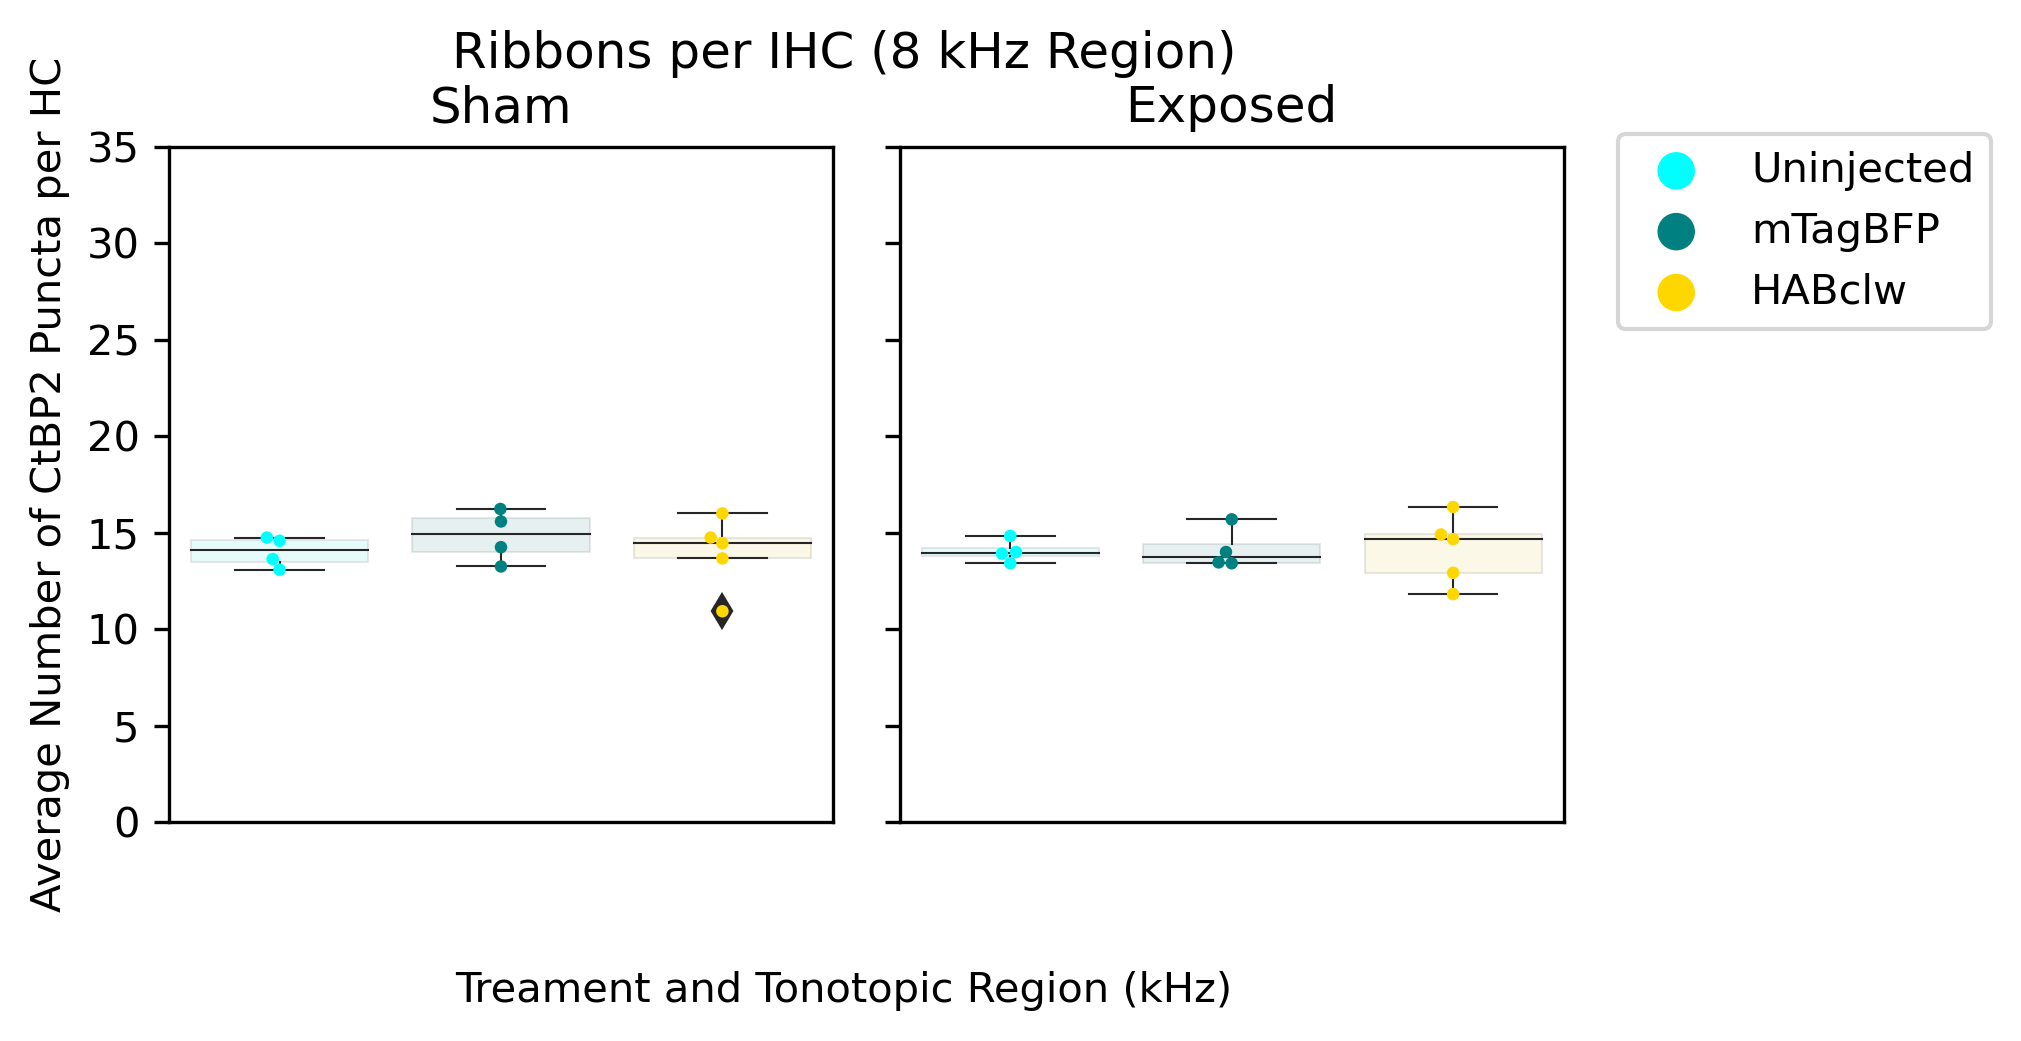

In [115]:
plot = 'RbPerHC'
plottype = 'BoxSwarm'
region = 'All'
title = 'Ribbons per IHC (8 kHz Region)'
# Order is the color coded condition along the x-axis at the lowest level (repeating between panels)
order = ['Uninjected','mTagBFP','HABclw']
colors = {order[0]:'aqua' , order[1]:'teal', order[2]:'gold'}
hue = 'Treatment'
x = 'Treatment'
y = 'AvgPunctaPerHC'
xlab = 'Treament and Tonotopic Region (kHz)'
ylab = 'Average Number of CtBP2 Puncta per HC'
markersize = 3

fig, axes = plt.subplots(1, 2, dpi=300,figsize=(6,3), sharey = True, sharex= True)
(ax1, ax2) = axes
fig.suptitle(title)
fig.text(0.5, -.1, xlab, ha='center')
plt.subplots_adjust(top = 0.85, bottom=0.1, hspace=.3, wspace=.1)

# *** MAKE THE FIRST SUBPLOT FOR 8 kHz DATA ***
ax1 = plt.subplot(121)  
ax1.title.set_text('Sham')
ax1 = sns.swarmplot(data=dfBM[(dfBM['Freq'] == '8.0') & (dfBM['NoiseExposed'] == 'Sham')], 
              x=x,y=y, hue=hue, palette=colors, order=order, size=markersize, legend = False, dodge = False)
sns.boxplot(data=dfBM[(dfBM['Freq'] == '8.0') & (dfBM['NoiseExposed'] == 'Sham')],
            x=x, y=y, hue=hue, palette=colors, order=order, boxprops={'alpha': 0.1}, ax=ax1, dodge = False,
           linewidth=.5)
ax1.set(ylabel=ylab)
ax1.set_ylim((0, 35))
ax1.get_legend().remove()
ax1.get_xaxis().set_visible(False)

# *** MAKE THE SECOND SUBPLOT FOR 16 kHz FREQUENCY DATA ***
ax2 = plt.subplot(122)  
ax2.title.set_text('Exposed')
ax2 = sns.swarmplot(data=dfBM[(dfBM['Freq'] == '8.0') & (dfBM['NoiseExposed'] == 'Exposed')], 
              x=x,y=y, hue=hue, palette=colors, order=order, size=markersize, legend = False, dodge = False)
sns.boxplot(data=dfBM[(dfBM['Freq'] == '8.0') & (dfBM['NoiseExposed'] == 'Exposed')],
            x=x, y=y, hue=hue, palette=colors, order=order, boxprops={'alpha': 0.1}, ax=ax2, dodge = False,
           linewidth=.5)
ax2.get_legend().remove()
ax2.axes.get_xaxis().set_visible(False)


# *** SETUP THE LEGEND FOR BOTH SUBPLOTS ***
plt.legend([order[0], order[1], order[2]], bbox_to_anchor=(1.05, 1.05),loc='upper left',   
           markerscale=3,fancybox=True)

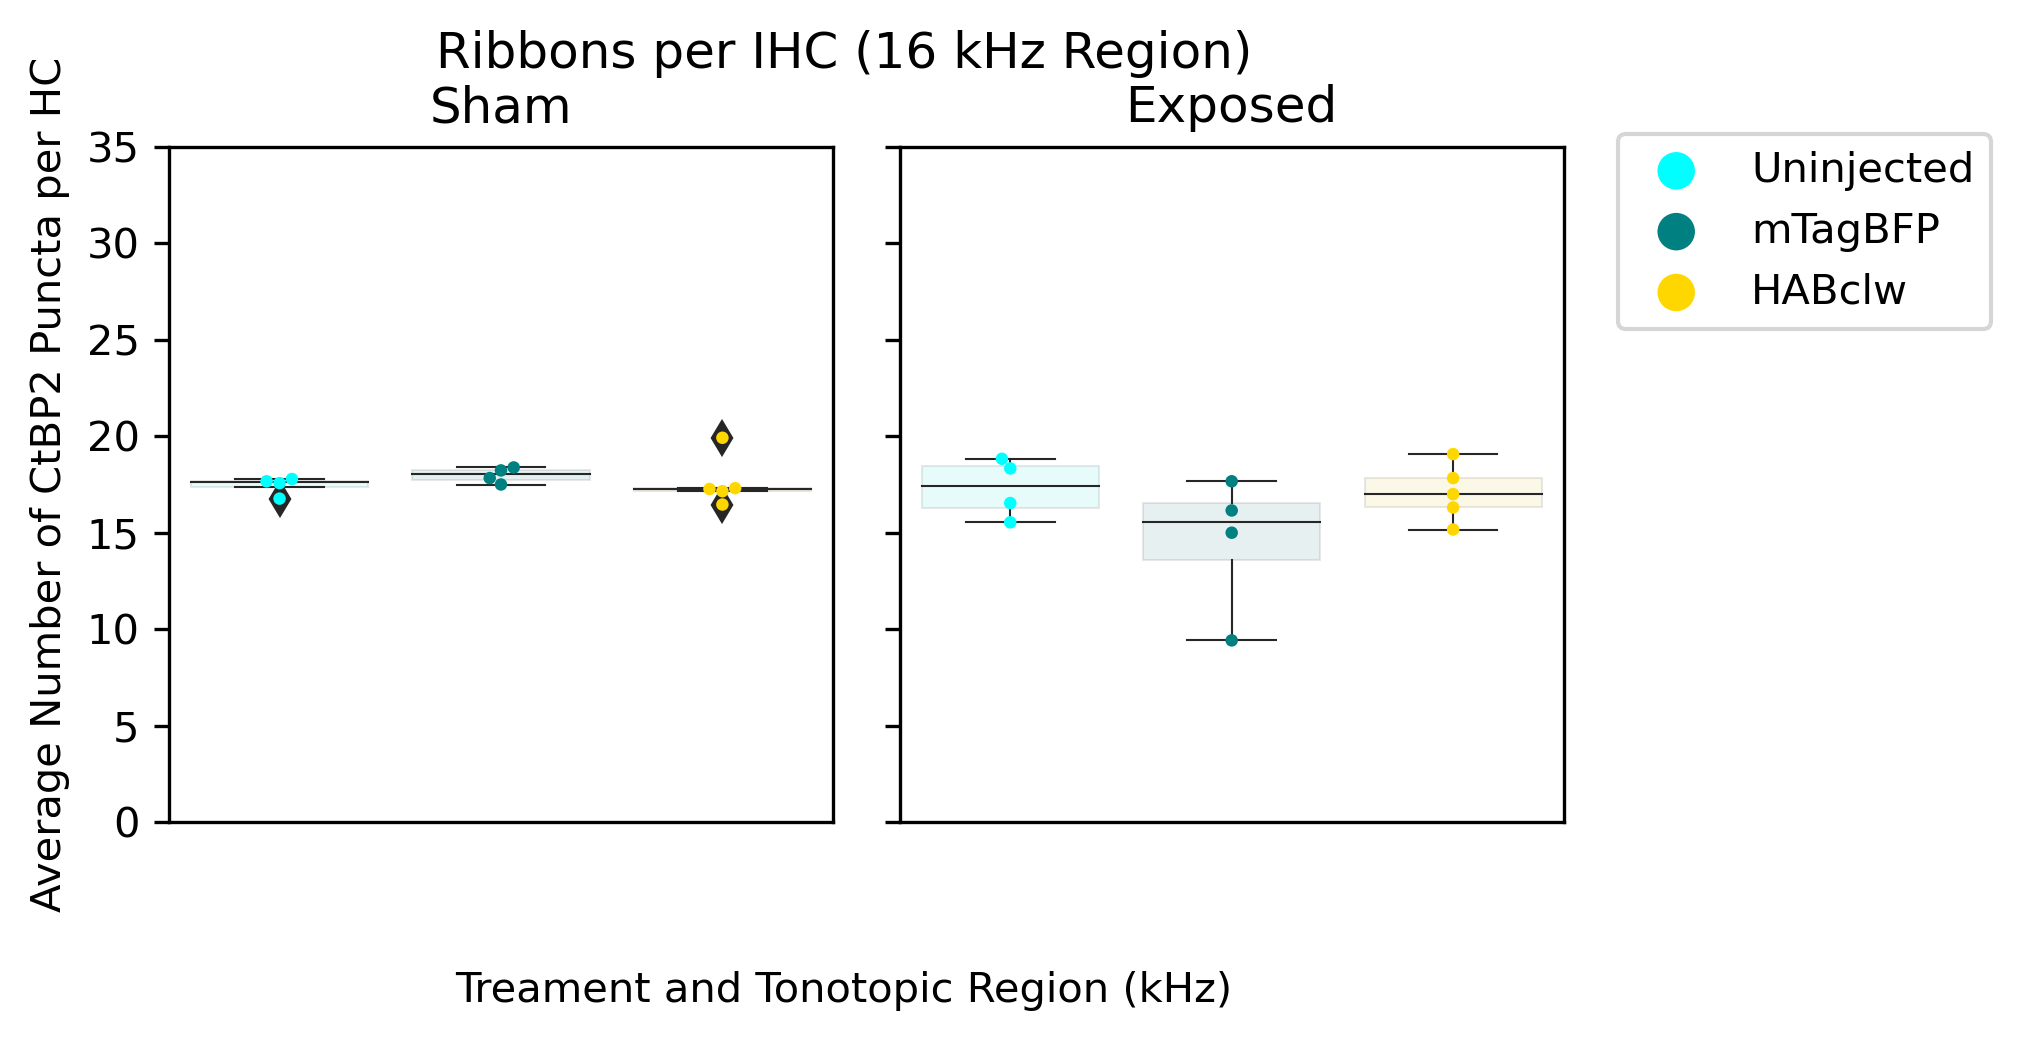

In [116]:
plot = 'RbPerHC'
plottype = 'BoxSwarm'
region = 'All'
title = 'Ribbons per IHC (16 kHz Region)'
# Order is the color coded condition along the x-axis at the lowest level (repeating between panels)
order = ['Uninjected','mTagBFP','HABclw']
colors = {order[0]:'aqua' , order[1]:'teal', order[2]:'gold'}
hue = 'Treatment'
x = 'Treatment'
y = 'AvgPunctaPerHC'
xlab = 'Treament and Tonotopic Region (kHz)'
ylab = 'Average Number of CtBP2 Puncta per HC'
markersize = 3

fig, axes = plt.subplots(1, 2, dpi=300,figsize=(6,3), sharey = True, sharex= True)
(ax1, ax2) = axes
fig.suptitle(title)
fig.text(0.5, -.1, xlab, ha='center')
plt.subplots_adjust(top = 0.85, bottom=0.1, hspace=.3, wspace=.1)

# *** MAKE THE FIRST SUBPLOT FOR 8 kHz DATA ***
ax1 = plt.subplot(121)  
ax1.title.set_text('Sham')
ax1 = sns.swarmplot(data=dfBM[(dfBM['Freq'] == '16.0') & (dfBM['NoiseExposed'] == 'Sham')], 
              x=x,y=y, hue=hue, palette=colors, order=order, size=markersize, legend = False, dodge = False)
sns.boxplot(data=dfBM[(dfBM['Freq'] == '16.0') & (dfBM['NoiseExposed'] == 'Sham')],
            x=x, y=y, hue=hue, palette=colors, order=order, boxprops={'alpha': 0.1}, ax=ax1, dodge = False,
           linewidth=.5)
ax1.set(ylabel=ylab)
ax1.set_ylim((0, 35))
ax1.get_legend().remove()
ax1.get_xaxis().set_visible(False)

# *** MAKE THE SECOND SUBPLOT FOR 16 kHz FREQUENCY DATA ***
ax2 = plt.subplot(122)  
ax2.title.set_text('Exposed')
ax2 = sns.swarmplot(data=dfBM[(dfBM['Freq'] == '16.0') & (dfBM['NoiseExposed'] == 'Exposed')], 
              x=x,y=y, hue=hue, palette=colors, order=order, size=markersize, legend = False, dodge = False)
sns.boxplot(data=dfBM[(dfBM['Freq'] == '16.0') & (dfBM['NoiseExposed'] == 'Exposed')],
            x=x, y=y, hue=hue, palette=colors, order=order, boxprops={'alpha': 0.1}, ax=ax2, dodge = False,
           linewidth=.5)
ax2.get_legend().remove()
ax2.axes.get_xaxis().set_visible(False)


# *** SETUP THE LEGEND FOR BOTH SUBPLOTS ***
plt.legend([order[0], order[1], order[2]], bbox_to_anchor=(1.05, 1.05),loc='upper left',   
           markerscale=3,fancybox=True)

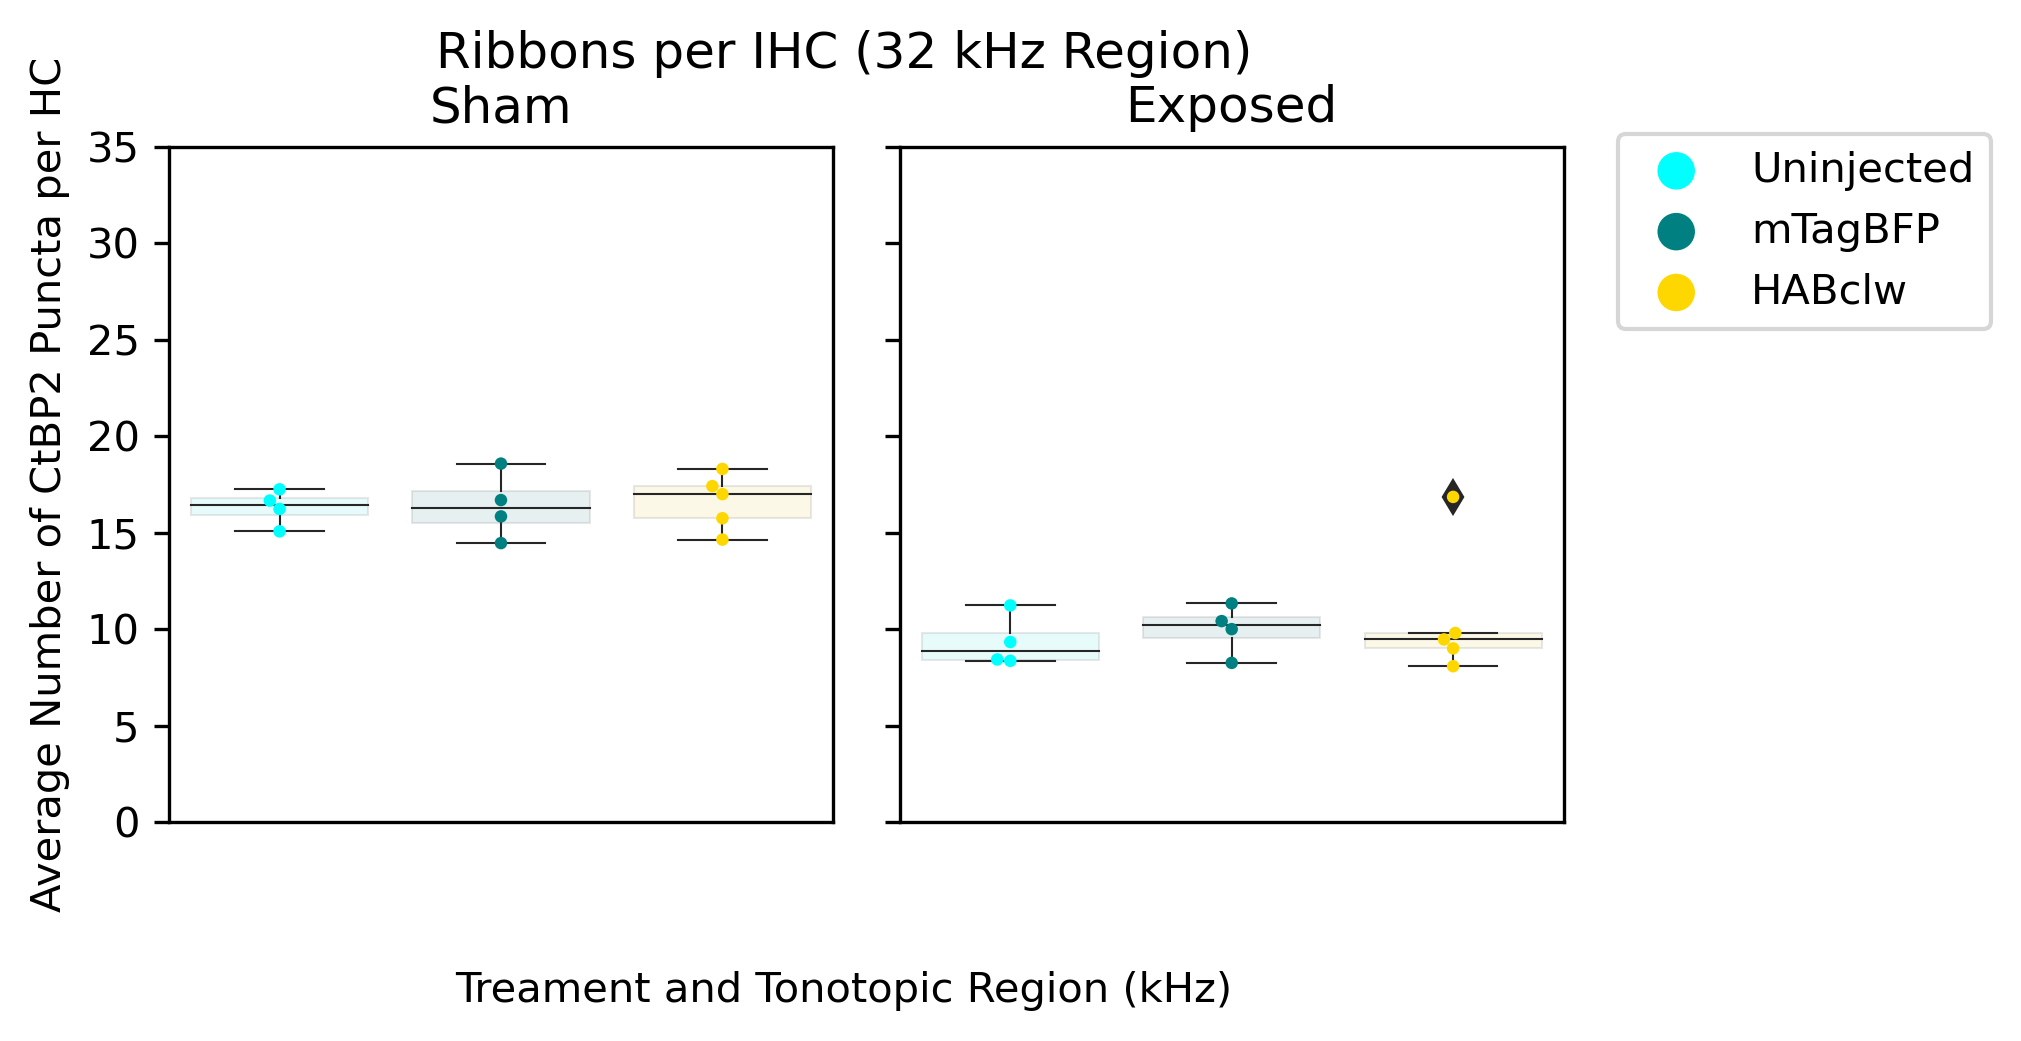

In [117]:
plot = 'RbPerHC'
plottype = 'BoxSwarm'
region = 'All'
title = 'Ribbons per IHC (32 kHz Region)'
# Order is the color coded condition along the x-axis at the lowest level (repeating between panels)
order = ['Uninjected','mTagBFP','HABclw']
colors = {order[0]:'aqua' , order[1]:'teal', order[2]:'gold'}
hue = 'Treatment'
x = 'Treatment'
y = 'AvgPunctaPerHC'
xlab = 'Treament and Tonotopic Region (kHz)'
ylab = 'Average Number of CtBP2 Puncta per HC'
markersize = 3

fig, axes = plt.subplots(1, 2, dpi=300,figsize=(6,3), sharey = True, sharex= True)
(ax1, ax2) = axes
fig.suptitle(title)
fig.text(0.5, -.1, xlab, ha='center')
plt.subplots_adjust(top = 0.85, bottom=0.1, hspace=.3, wspace=.1)

# *** MAKE THE FIRST SUBPLOT FOR 8 kHz DATA ***
ax1 = plt.subplot(121)  
ax1.title.set_text('Sham')
ax1 = sns.swarmplot(data=dfBM[(dfBM['Freq'] == '32.0') & (dfBM['NoiseExposed'] == 'Sham')], 
              x=x,y=y, hue=hue, palette=colors, order=order, size=markersize, legend = False, dodge = False)
sns.boxplot(data=dfBM[(dfBM['Freq'] == '32.0') & (dfBM['NoiseExposed'] == 'Sham')],
            x=x, y=y, hue=hue, palette=colors, order=order, boxprops={'alpha': 0.1}, ax=ax1, dodge = False,
           linewidth=.5)
ax1.set(ylabel=ylab)
ax1.set_ylim((0, 35))
ax1.get_legend().remove()
ax1.get_xaxis().set_visible(False)

# *** MAKE THE SECOND SUBPLOT FOR 16 kHz FREQUENCY DATA ***
ax2 = plt.subplot(122)  
ax2.title.set_text('Exposed')
ax2 = sns.swarmplot(data=dfBM[(dfBM['Freq'] == '32.0') & (dfBM['NoiseExposed'] == 'Exposed')], 
              x=x,y=y, hue=hue, palette=colors, order=order, size=markersize, legend = False, dodge = False)
sns.boxplot(data=dfBM[(dfBM['Freq'] == '32.0') & (dfBM['NoiseExposed'] == 'Exposed')],
            x=x, y=y, hue=hue, palette=colors, order=order, boxprops={'alpha': 0.1}, ax=ax2, dodge = False,
           linewidth=.5)
ax2.get_legend().remove()
ax2.axes.get_xaxis().set_visible(False)


# *** SETUP THE LEGEND FOR BOTH SUBPLOTS ***
plt.legend([order[0], order[1], order[2]], bbox_to_anchor=(1.05, 1.05),loc='upper left',   
           markerscale=3,fancybox=True)